# COCO Reader with augumentations

Reader operator that reads a COCO dataset (or subset of COCO), which consists of an annotation file and the images directory.

In [1]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types
import numpy as np
from time import time

subset = "val"
file_root = "/data/coco/coco-2017/coco2017/" + subset + "2017"
annotations_file = "/data/coco/coco-2017/coco2017/annotations/instances_" + subset + "2017.json"
num_gpus = 1
batch_size = 16

Create reader, decoder and flip operator for images and bounding boxes

In [2]:
class COCOPipeline(Pipeline):                                                                    
    def __init__(self, batch_size, num_threads, device_id):                                       
        super(COCOPipeline, self).__init__(batch_size, num_threads, device_id, seed = 15)        
        self.input = ops.COCOReader(file_root = file_root, annotations_file = annotations_file,
                                     shard_id = device_id, num_shards = num_gpus, ratio=True)
        self.decode = ops.nvJPEGDecoder(device = "mixed", output_type = types.RGB)
        self.flip = ops.Flip(device = "gpu")
        self.bbflip = ops.BbFlip(device = "cpu")
        self.coin = ops.CoinFlip(probability=0.5)
        self.coin2 = ops.CoinFlip(probability=0.5)
                                                                                                  
    def define_graph(self):                                                                       
        inputs, bboxes, labels = self.input()            
        images = self.decode(inputs)
        rng = self.coin()
        rng2 = self.coin2()
        images = self.flip(images, horizontal = rng, vertical = rng2)
        bboxes = self.bbflip(bboxes, horizontal = rng, vertical = rng2)
        return (images, bboxes, labels)                                                         

In [3]:
start = time()
pipes = [COCOPipeline(batch_size=batch_size, num_threads=2, device_id = device_id)  for device_id in range(num_gpus)]
for pipe in pipes:
    pipe.build()
total_time = time() - start
print("Computation graph built and dataset loaded in %f seconds." % total_time)

Computation graph built and dataset loaded in 0.796270 seconds.


In [4]:
pipe_out = [pipe.run() for pipe in pipes]                                                   

images_cpu = pipe_out[0][0].asCPU()
bboxes_cpu = pipe_out[0][1]
labels_cpu = pipe_out[0][2]

Bounding boxes returned by the operator are lists of floats containing composed of **\[x, y, width, height]** (`ltrb` is set to `False` by default).

In [5]:
bboxes = bboxes_cpu.at(4)
bboxes

array([[0.29334375, 0.01505155, 0.48499998, 0.9806443 ],
       [0.6219219 , 0.20796393, 0.12675   , 0.09484536],
       [0.23195311, 0.18443298, 0.14375   , 0.11409794],
       [0.17071876, 0.06840207, 0.01342188, 0.02981959],
       [0.14854687, 0.17430411, 0.01076563, 0.02149484],
       [0.5690781 , 0.22311856, 0.04889063, 0.06100516],
       [0.127     , 0.1964433 , 0.04189062, 0.04719072],
       [0.1915625 , 0.2041237 , 0.01457812, 0.03840206],
       [0.7907031 , 0.06510309, 0.20929687, 0.28858247],
       [0.61985934, 0.20796393, 0.12832811, 0.09164949],
       [0.74493754, 0.2091495 , 0.0681875 , 0.10172681],
       [0.05101563, 0.15054123, 0.00817188, 0.00889175]], dtype=float32)

Let's see the ground truth bounding boxes drawn on the image.

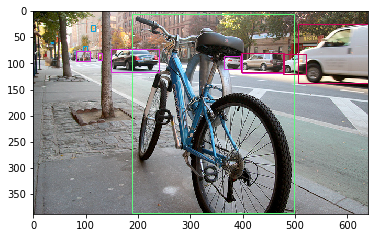

In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

img_index = 4

img = images_cpu.at(img_index)

H = img.shape[0]
W = img.shape[1]

fig,ax = plt.subplots(1)

ax.imshow(img)
bboxes = bboxes_cpu.at(img_index)
labels = labels_cpu.at(img_index)
categories_set = set()
for label in labels:
    categories_set.add(label[0])

category_id_to_color = dict([ (cat_id , [random.uniform(0, 1) ,random.uniform(0, 1), random.uniform(0, 1)]) for cat_id in categories_set])

for bbox, label in zip(bboxes, labels):
    rect = patches.Rectangle((bbox[0]*W,bbox[1]*H),bbox[2]*W,bbox[3]*H,linewidth=1,edgecolor=category_id_to_color[label[0]],facecolor='none')
    ax.add_patch(rect)

plt.show()
